# Visualization

In this Notebook the general Visualization of the dataset is implemented and shown. 
Additionally some Analytics in regards to ball visibility etc. is performed

### imports

In [35]:
import pandas as pd
import numpy as np
import json
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import cv2
import os
import numpy as np

In [36]:
# read annotation json
with open('../00_Dataset/annotations.json') as f:
    data = json.load(f)

### define plot style

In [37]:
# Define D3 Category 10 colors
d3_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf'   # Cyan
]

# Set D3 colors as the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=d3_colors)


def set_plot_style_default():
    # General font settings
    plt.rcParams['font.family'] = 'Sans Serif' # Use Ariel like overleaf
    plt.rcParams['font.size'] = 12             # Base font size for readability
    plt.rcParams['axes.titlesize'] = 14        # Larger title font size
    plt.rcParams['axes.labelsize'] = 12        # Label font size
    plt.rcParams['xtick.labelsize'] = 10       # X-tick font size
    plt.rcParams['ytick.labelsize'] = 10       # Y-tick font size
    plt.rcParams['legend.fontsize'] = 10       # Legend font size
    
    # Line and marker settings
    plt.rcParams['lines.linewidth'] = 1.5      # Make lines thicker for better visibility
    plt.rcParams['lines.markersize'] = 6       # Standard marker size
    
    # Axes and grid settings
    plt.rcParams['axes.grid'] = True           # Enable grid
    plt.rcParams['grid.linestyle'] = '--'      # Use dashed line for grid
    plt.rcParams['grid.alpha'] = 0.7           # Grid transparency
    plt.rcParams['axes.edgecolor'] = 'black'   # Black border around plot area
    plt.rcParams['axes.linewidth'] = 1         # Border line thickness

    # Ensure grid is below the plot elements
    plt.rcParams['axes.axisbelow'] = True      # Grid lines below plot elements

    # Legend settings
    plt.rcParams['legend.frameon'] = True      # Frame around the legend
    plt.rcParams['legend.framealpha'] = 0.9    # Slightly transparent legend background
    plt.rcParams['legend.loc'] = 'best'        # Automatically place legend in the best location

    # Tick direction
    plt.rcParams['xtick.direction'] = 'in'     # Inward tick direction for x-axis
    plt.rcParams['ytick.direction'] = 'in'     # Inward tick direction for y-axis


## Visualization of Objects

In [38]:
def get_object_for_frame(clip, frame):
    objects = {}
    objects['players'] = []
    objects['balls'] = []
    objects['court_lines'] = []
    objects['nets'] = []
    objects['keypoints'] = {}


    objects['players'] = clip['frames_with_objects'][frame]['players']
    objects['balls'] = clip['frames_with_objects'][frame]['balls']
    objects['court_lines'] = clip['frames_with_objects'][frame]['court_lines']
    objects['nets'] = clip['frames_with_objects'][frame]['nets']
    if len(clip['frames_with_objects'][frame]['keypoints'])>0:
        objects['keypoints'] = clip['frames_with_objects'][frame]['keypoints'][0]['points']

    return objects


# function that returns random frames with specific conditions
def get_random_frames(dataset, ball_visibility= None, ball_trajectory= None, limit = 35):
    clips = []

    while len(clips) < limit:
        #select random video
        video = np.random.choice(dataset)
        #select random clip
        clip = np.random.choice(video['clips'])

        clip
        
        # filter frames with objects based on ball visibility and trajectory
        frames = []

        for frame_id, frame in clip['frames_with_objects'].items():
            # if both conditions are None, add all frames
            if ball_visibility == None and ball_trajectory == None:
                frames.append(frame_id)
                continue
            # check if balls are visible
            if len(frame['balls']) == 0:
                continue
            for ball in frame['balls']:
                if (ball['visibility'] == ball_visibility or ball_visibility == None) and (ball['trajectory'] == ball_trajectory or ball_trajectory == None):
                    frames.append(frame_id)
                    break
            
        # select random frame
        if len(frames) > 0:
            frame = np.random.choice(frames)
        else:
            continue

        # get all objects at this frame
        objects = get_object_for_frame(clip, frame)

        return video['name'], clip['name'], frame, objects
    
    return None
        

#get and print random frame
video_name, clip_file, frame, objects = get_random_frames(data["subsets"][0]['videos'], 'Visible', 'Flying')
print(video_name, clip_file, frame)

Video_1 clip_1 79


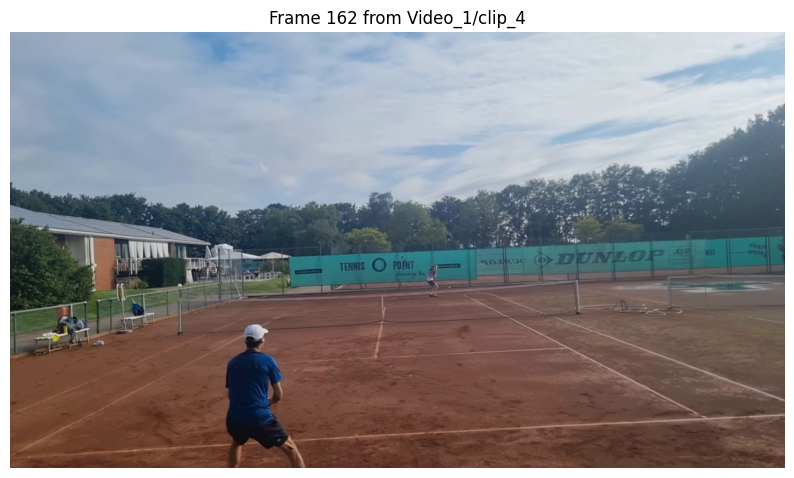

In [39]:
def extract_frame(subset, video_name, clip_name, frame_number, dataset_folder = "../00_Dataset"):
    # Construct the full path to the frame
    frame_path = os.path.join(dataset_folder, subset, video_name, clip_name, str(frame_number) + ".jpg")
    
    # Check if the file exists
    if not os.path.exists(frame_path):
        raise FileNotFoundError(f"The frame {frame_number} in {video_name}/{clip_name} does not exist")
    
    frame = cv2.imread(frame_path)

    return frame

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# Display the frame
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Frame {frame_number} from {video_name}/{clip_name}")

plt.show()

### draw objects

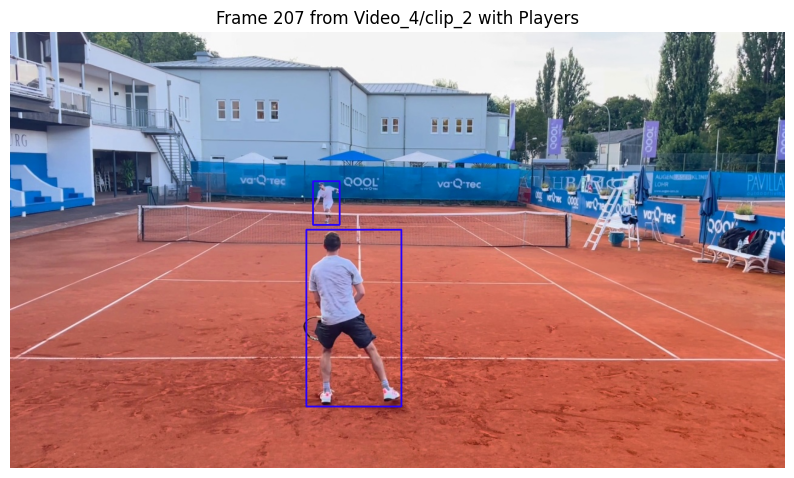

In [40]:
def hex_to_bgr(hex_color):
    hex_color = hex_color.lstrip('#')
    
    # Convert hex to RGB, then reverse to get BGR for OpenCV
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    bgr = rgb[::-1]  
    return bgr

# function to draw all players in a frame
def draw_players(frame, players, color):
    # Create a copy of the frame
    frame_copy = frame.copy()
    
    # Draw a bounding box for each player
    for player in players:
        # Get the coordinates of the bounding box round float to int
        x1 = int(float(player['xtl']))
        y1 = int(float(player['ytl']))
        x2 = int(float(player['xbr']))
        y2 = int(float(player['ybr']))
        
        # Draw the bounding box
        cv2.rectangle(frame_copy, (x1, y1), (x2, y2), color, 2)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# get player color
player_color = hex_to_bgr(data['labels'][0]['color'])

# draw players on the frame
frame_with_players = draw_players(frame, objects['players'], player_color)

# Display the frame with players
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_players, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Frame {frame_number} from {video_name}/{clip_name} with Players")

plt.show()

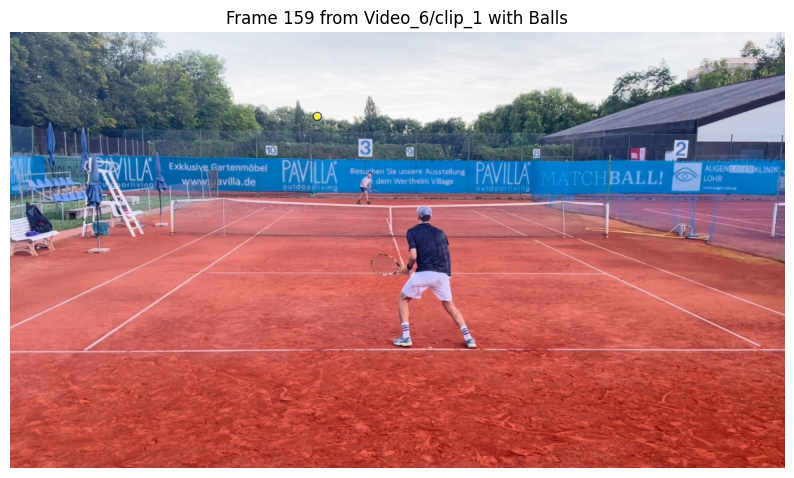

In [41]:
# function to draw all balls in a frame
def draw_balls(frame, balls, color, fill=True, outline=True):
    frame_copy = frame.copy()
    
    # Draw a bounding box for each ball
    for ball in balls:
        # Get the coordinates of the bounding box round float to int
        x = int(float(ball['x']))
        y = int(float(ball['y']))
        
        # Draw the bounding box
        if fill:
            cv2.circle(frame_copy, (x, y), 4, color, -1, lineType=cv2.LINE_AA)
        # Draw a larger circle around the ball in black
        if outline:
            cv2.circle(frame_copy, (x, y), 7, (0, 0, 0), 1, lineType=cv2.LINE_AA)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)
     
# get ball color
ball_color = hex_to_bgr(data['labels'][1]['color'])

# draw balls on the frame
frame_with_balls = draw_balls(frame, objects["balls"], ball_color)

# Display the frame with balls
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_balls, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Frame {frame_number} from {video_name}/{clip_name} with Balls")

plt.show()

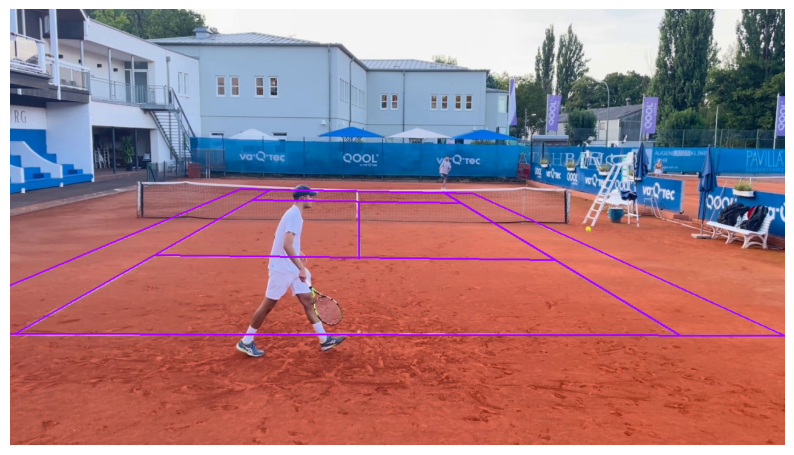

In [42]:
# function to draw all court lines in a frame
def draw_court_lines(frame, court_lines, color):
    frame_copy = frame.copy()
    
    # Draw a bounding box for each court line
    for line in court_lines:
        # Get the coordinates of the bounding box round float to int
        x1 = int(float(line['x1']))
        y1 = int(float(line['y1']))
        x2 = int(float(line['x2']))
        y2 = int(float(line['y2']))
        
        # Draw the bounding box
        cv2.line(frame_copy, (x1, y1), (x2, y2), color, 2)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# get court line color
court_line_color = hex_to_bgr(data['labels'][2]['color'])

# draw court lines on the frame
frame_with_court_lines = draw_court_lines(frame, objects["court_lines"], court_line_color)

# Display the frame with court lines
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_court_lines, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

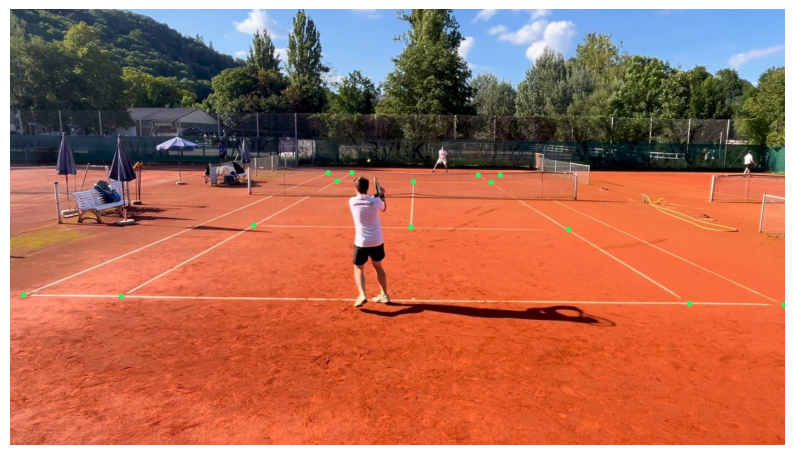

In [43]:
# draw keypoints on the frame
def draw_keypoints(frame, keypoints, color):
    # Create a copy of the frame
    frame_copy = frame.copy()

    # Draw a circle for each keypoint
    for key,value in keypoints.items():
        if value is not None:
            # Get the coordinates of the keypoint round float to int
            x = int(float(value[0]))
            y = int(float(value[1]))
        
        # Draw the keypoint
        cv2.circle(frame_copy, (x, y), 4, color, -1, lineType=cv2.LINE_AA)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# get keypoint color
keypoint_color = hex_to_bgr(data['labels'][4]['color'])

# draw keypoints on the frame
frame_with_keypoints = draw_keypoints(frame, objects["keypoints"], keypoint_color)

# Display the frame with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

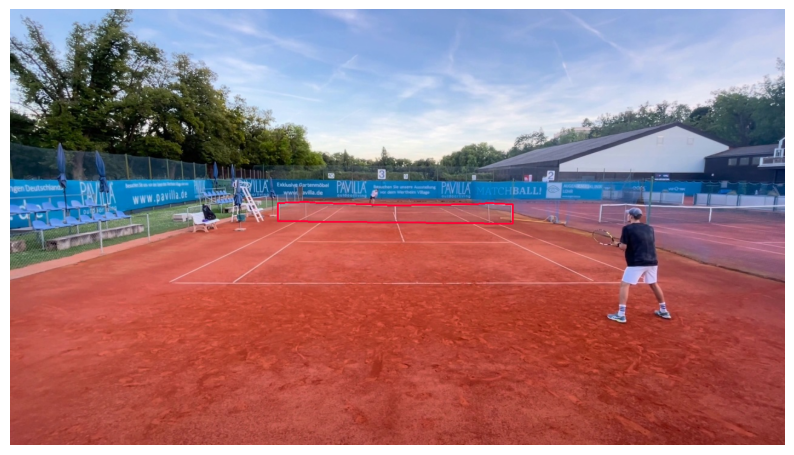

In [44]:
# function to draw all nets in a frame
def draw_nets(frame, nets, color):
    # Create a copy of the frame
    frame_copy = frame.copy()
    
    # Draw a bounding box for each net
    for net in nets:
        points = net['points']
        polygon_points = np.array(
            [[int(round(float(point['x']))), int(round(float(point['y'])))] for point in points],
            np.int32
        )
        polygon_points = polygon_points.reshape((-1, 1, 2))
        
        # Draw the polygon on the frame copy
        cv2.polylines(frame_copy, [polygon_points], isClosed=True, color=color, thickness=2)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# get net color
net_color = hex_to_bgr(data['labels'][3]['color'])

# draw nets on the frame
frame_with_nets = draw_nets(frame, objects["nets"], net_color)

# Display the frame with nets
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_nets, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

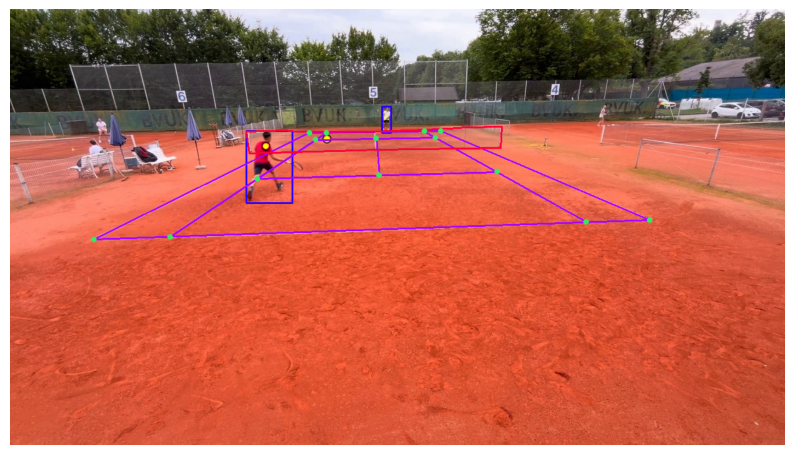

In [45]:
# function to draw all objects in a frame
def draw_objects(frame, objects, player=True, ball=True, court_line=True, net=True, keypoint=True):
    # Create a copy of the frame
    frame_copy = frame.copy()
    
    # draw players
    if player:
        players = objects['players']
        player_color = hex_to_bgr(data['labels'][0]['color'])
        frame_copy = draw_players(frame_copy, players, player_color)
    # draw balls
    if ball:
        balls = objects['balls']
        ball_color = hex_to_bgr(data['labels'][1]['color'])
        frame_copy = draw_balls(frame_copy, balls, ball_color)
    # draw court lines
    if court_line:
        court_lines = objects['court_lines']
        court_line_color = hex_to_bgr(data['labels'][2]['color'])
        frame_copy = draw_court_lines(frame_copy, court_lines, court_line_color)
    # draw nets
    if net:
        nets = objects['nets']
        net_color = hex_to_bgr(data['labels'][3]['color'])
        frame_copy = draw_nets(frame_copy, nets, net_color)
    # draw keypoints
    if keypoint:
        keypoints = objects['keypoints']
        keypoint_color = hex_to_bgr(data['labels'][4]['color'])
        frame_copy = draw_keypoints(frame_copy, keypoints, keypoint_color)

    return frame_copy

# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], "Visible", "Flying")
frame = extract_frame("Amateur", video_name, clip_name, frame_number)

# draw all objects on the frame
frame_with_objects = draw_objects(frame, objects)

# Display the frame with all objects
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_objects, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

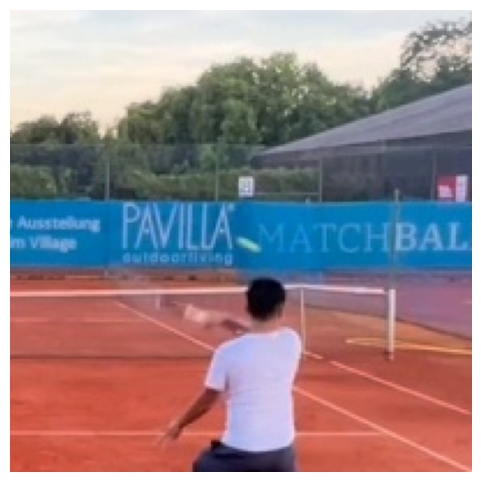

In [46]:
def get_ball_zoom_image(margin=100, visibility="Blurry" ,trajectory="Flying", fill=False, outline=False):
    # extract random frame
    video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][0]['videos'], visibility, trajectory)
    frame = extract_frame("Amateur", video_name, clip_name, frame_number)
        
    # get ball color
    ball_color = hex_to_bgr(data['labels'][1]['color'])

    # draw balls on the frame
    frame_with_balls = draw_balls(frame, objects["balls"], ball_color, fill=fill, outline=outline)

    # zoom at the location of the ball with a margin
    ball = objects["balls"][0]
    x = int(float(ball['x']))
    y = int(float(ball['y']))
    x1 = max(0, x - margin)
    y1 = max(0, y - margin)
    x2 = min(frame.shape[1], x + margin)
    y2 = min(frame.shape[0], y + margin)

    # crop the frame
    zoomed_frame = frame_with_balls[y1:y2, x1:x2]

    # Display the zoomed frame with balls without border
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(zoomed_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

get_ball_zoom_image()

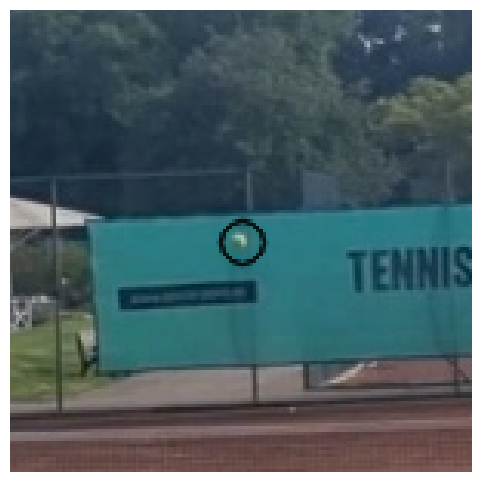

In [47]:
get_ball_zoom_image(margin=75,visibility="Visible", trajectory="Flying", fill=False, outline=True)

### visualize other subsets

In [48]:
print(data["subsets"][2]["name"])

Court


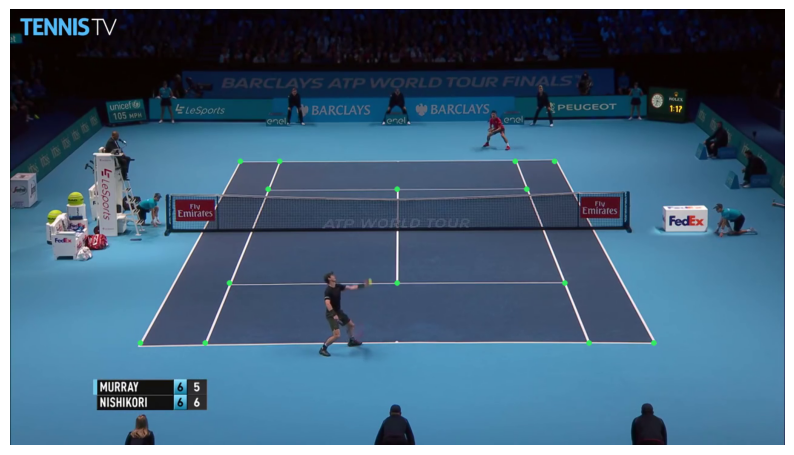

In [65]:
# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][2]['videos'])
frame = extract_frame(data["subsets"][2]["name"], video_name, clip_name, frame_number)

# draw all objects on the frame
frame_with_objects = draw_objects(frame, objects)

# Display the frame with all objects
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_objects, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

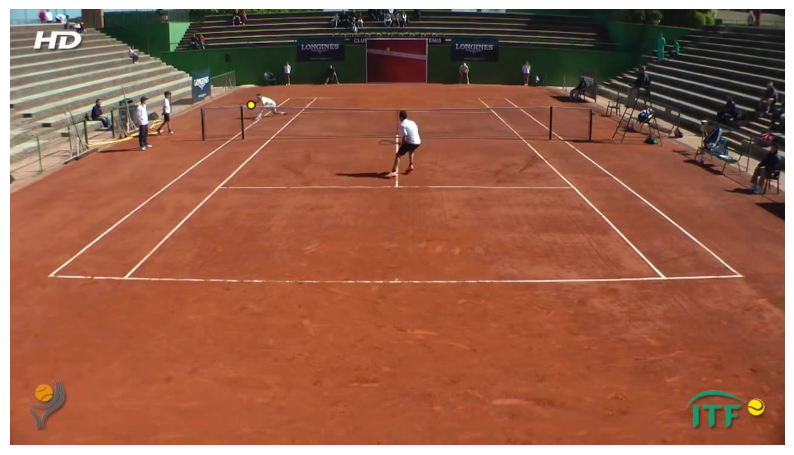

In [67]:
# extract random frame
video_name, clip_name, frame_number, objects = get_random_frames(data["subsets"][1]['videos'])
frame = extract_frame(data["subsets"][1]["name"], video_name, clip_name, frame_number)

# draw all objects on the frame
frame_with_objects = draw_objects(frame, objects)

# Display the frame with all objects
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame_with_objects, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Exploratory data analysis

In [68]:
# get total number of frames
total_frames = 0
clips = 0
videos = 0
for subset in data["subsets"]:
    for video in subset['videos']:
        videos += 1
        for clip in video['clips']:
            clips += 1
            total_frames += len(clip['frames_with_objects'].keys())

print(f"Total number of frames: {total_frames}")
print(f"Total number of clips: {clips}")
print(f"Total number of videos: {videos}")

Total number of frames: 40217
Total number of clips: 628
Total number of videos: 514


In [69]:
clip_length = []
# get average clip length for each subset
for subset in data["subsets"]:
    total_frames = 0
    clips = 0
    clip_length_subset = []
    for video in subset['videos']:
        for clip in video['clips']:
            clips += 1
            total_frames += len(clip['frames_with_objects'].keys())
            clip_length_subset.append(len(clip['frames_with_objects'].keys()))

    clip_length.append(clip_length_subset)

    print(f"Average clip length for {subset['name']}: {total_frames / clips }")


Average clip length for Amateur: 329.74285714285713
Average clip length for TrackNet: 208.78947368421052
Average clip length for Court: 17.753012048192772


In [70]:
# get min max and average clip length for each subset
for i, subset in enumerate(data["subsets"]):
    print(f"Min clip length for {subset['name']}: {min(clip_length[i])}")
    print(f"Max clip length for {subset['name']}: {max(clip_length[i])}")
    print(f"Average clip length for {subset['name']}: {np.mean(clip_length[i])}")

Min clip length for Amateur: 180
Max clip length for Amateur: 660
Average clip length for Amateur: 329.74285714285713
Min clip length for TrackNet: 29
Max clip length for TrackNet: 901
Average clip length for TrackNet: 208.78947368421052
Min clip length for Court: 1
Max clip length for Court: 71
Average clip length for Court: 17.753012048192772


In [71]:
#count objects for each subset
objects_count = []
for subset in data["subsets"]:
    players = 0
    balls = 0
    court_lines = 0
    nets = 0
    keypoints = 0
    for video in subset['videos']:
        for clip in video['clips']:
            players += clip['num_players']
            balls += clip['num_balls']
            court_lines += clip['num_court_lines']
            nets += clip['num_nets']
            keypoints += clip['num_keypoints']
    
    objects_count.append({
        "players": players,
        "balls": balls,
        "court_lines": court_lines,
        "nets": nets,
        "keypoints": keypoints
    })

# print objects count for each subset
for i, subset in enumerate(data["subsets"]):
    print(f"Objects count for {subset['name']}:")
    print(f"Players: {objects_count[i]['players']}")
    print(f"Balls: {objects_count[i]['balls']}")
    print(f"Court Lines: {objects_count[i]['court_lines']}")
    print(f"Nets: {objects_count[i]['nets']}")
    print(f"Keypoints: {objects_count[i]['keypoints']}")
    print()

# total
print("Total objects count:")
print(f"Players: {sum([count['players'] for count in objects_count])}")
print(f"Balls: {sum([count['balls'] for count in objects_count])}")
print(f"Court Lines: {sum([count['court_lines'] for count in objects_count])}")
print(f"Nets: {sum([count['nets'] for count in objects_count])}")
print(f"Keypoints: {sum([count['keypoints'] for count in objects_count])}")


Objects count for Amateur:
Players: 72
Balls: 53
Court Lines: 315
Nets: 35
Keypoints: 35

Objects count for TrackNet:
Players: 0
Balls: 95
Court Lines: 0
Nets: 0
Keypoints: 0

Objects count for Court:
Players: 0
Balls: 0
Court Lines: 0
Nets: 0
Keypoints: 498

Total objects count:
Players: 72
Balls: 148
Court Lines: 315
Nets: 35
Keypoints: 533


### Ball Attribute Analysis

In [72]:
# replace blanc trajectory with unknown
for subset in data["subsets"]:
    for video in subset['videos']:
        for clip in video['clips']:
            for frame_number,frame in clip['frames_with_objects'].items():
                for ball in frame['balls']:
                    if ball['trajectory'] == "":
                        ball['trajectory'] = "Unknown"

In [73]:
# get distribution of visibilitie classes
visibility_distribution = {}
trajectory_distribution = {}
count_balls = {}
for subset in data["subsets"]:
    count_sub = 0
    visibility_distribution[subset['name']] = {}
    trajectory_distribution[subset['name']] = {}
    for video in subset['videos']:
        for clip in video['clips']:
            for frame_number,frame in clip['frames_with_objects'].items():
                for ball in frame['balls']:
                    count_sub += 1
                    visibility = ball['visibility']
                    trajectory = ball['trajectory']

                    if visibility not in visibility_distribution[subset['name']]:
                        visibility_distribution[subset['name']][visibility] = 0
                    if trajectory not in trajectory_distribution[subset['name']]:
                        trajectory_distribution[subset['name']][trajectory] = 0

                    visibility_distribution[subset['name']][visibility] += 1
                    trajectory_distribution[subset['name']][trajectory] += 1

    count_balls[subset['name']] = count_sub

# print visibility distribution for each subset
for subset, distribution in visibility_distribution.items():
    print(f"Visibility distribution for {subset}:")
    for visibility, count in distribution.items():
        print(f"{visibility}: {count} ({count/count_balls[subset]})" )
    print()

# print trajectory distribution for each subset
for subset, distribution in trajectory_distribution.items():
    print(f"Trajectory distribution for {subset}:")
    for trajectory, count in distribution.items():
        print(f"{trajectory}: {count} ({count/count_balls[subset]})" )
    print()
    

Visibility distribution for Amateur:
Visible: 11841 (0.8300736067297582)
Occluded: 348 (0.024395373291272344)
Difficult: 1740 (0.12197686645636173)
Outside: 95 (0.006659656501927795)
Blurry: 241 (0.016894497020679987)

Visibility distribution for TrackNet:
Visible: 17632 (0.8889337030501638)
Difficult: 1392 (0.07017897655659189)
Outside: 729 (0.03675321401562894)
Occluded: 82 (0.004134106377615326)

Visibility distribution for Court:

Trajectory distribution for Amateur:
Flying: 9802 (0.6871363477041711)
Bounce: 205 (0.014370837714686295)
Hit: 178 (0.012478093235191027)
Static: 4080 (0.28601472134595163)

Trajectory distribution for TrackNet:
Flying: 18067 (0.9108646332240988)
Hit: 516 (0.026014620620115957)
Bounce: 523 (0.02636753214015629)
Unknown: 729 (0.03675321401562894)

Trajectory distribution for Court:



In [74]:
set_plot_style_default()

counts_visibility = pd.DataFrame(visibility_distribution)
counts_trajectory = pd.DataFrame(trajectory_distribution)

#remove subset 3
counts_visibility = counts_visibility.drop(data["subsets"][2]['name'], axis=1)
counts_trajectory = counts_trajectory.drop(data["subsets"][2]['name'], axis=1)

# Calculate total for each subset (ignoring NaNs)
totals_vis = counts_visibility.sum(axis=0, skipna=True)
totals_traj = counts_trajectory.sum(axis=0, skipna=True)

# Normalize each column by its respective total
normalized_vis = counts_visibility.div(totals_vis, axis=1)
normalized_traj = counts_trajectory.div(totals_traj, axis=1)

# combine norm and absolute values
combined_vis = pd.concat([counts_visibility, normalized_vis], keys=['Absolute', 'Normalized'])
combined_traj = pd.concat([counts_trajectory, normalized_traj], keys=['Absolute', 'Normalized'])


In [75]:
# fill NaN values with 0
combined_vis = combined_vis.fillna(0)
combined_traj = combined_traj.fillna(0)
combined_vis

Amateur      TrackNet
Absolute   Visible    11841.000000  17632.000000
           Occluded     348.000000     82.000000
           Difficult   1740.000000   1392.000000
           Outside       95.000000    729.000000
           Blurry       241.000000      0.000000
Normalized Visible        0.830074      0.888934
           Occluded       0.024395      0.004134
           Difficult      0.121977      0.070179
           Outside        0.006660      0.036753
           Blurry         0.016894      0.000000

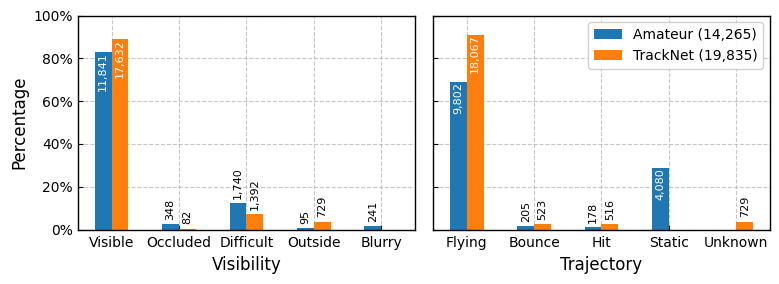

In [76]:
set_plot_style_default()
 
# Plotting side-by-side with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot for normalized visibility data
normalized_vis.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'])

# Calculate the total frames for each subset
total_frames_vis = counts_visibility.sum().to_dict()
total_frames_traj = counts_trajectory.sum().to_dict()

# Update the legend labels with total frames in braces
visibility_labels = [f"{col} ({int(total_frames_vis[col]):,})" for col in counts_visibility.columns]
trajectory_labels = [f"{col} ({int(total_frames_traj[col]):,})" for col in counts_trajectory.columns]

ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax1.set_xlabel('Visibility')
ax1.set_ylabel('Percentage')
ax1.xaxis.set_tick_params(pad=5)

# Add absolute values as labels on top of each bar for visibility
for container, col in zip(ax1.containers, counts_visibility.columns):
    for i, bar in enumerate(container):
        absolute_value = counts_visibility[col].iloc[i]
        if pd.notna(absolute_value):
            # Check if the bar height is sufficient to fit the text inside
            if bar.get_height() > 0.2:  # Adjust the threshold as needed
                va_position = 'top'  # Text inside the bar
                color = 'white' # Contrast color for better readability
                height = bar.get_height()
            else:
                va_position = 'bottom'  # Text above the bar
                height = bar.get_height() + 0.02
                color = 'black'
            
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(absolute_value):,}',
                ha='center', va=va_position, fontsize=8, rotation=90, color=color
            )

# Plot for normalized trajectory data
normalized_traj.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e'])
ax2.set_xlabel('Trajectory')

# Add absolute values as labels on top of each bar for trajectory
for container, col in zip(ax2.containers, counts_trajectory.columns):
    for i, bar in enumerate(container):
        absolute_value = counts_trajectory[col].iloc[i]
        if pd.notna(absolute_value):
            # Check if the bar height is sufficient to fit the text inside
            if bar.get_height() > 0.2:  # Adjust the threshold as needed
                va_position = 'top'  # Text inside the bar
                color = 'white' # Contrast color for better readability
                height = bar.get_height()
            else:
                va_position = 'bottom'  # Text above the bar
                height = bar.get_height() + 0.02
                color = 'black'
            
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(absolute_value):,}',
                ha='center', va=va_position, fontsize=8, rotation=90, color=color
            )

# Set y-axis limit to 1 for both subplots
ax1.set_ylim(0, 1)

# no legend on ax 1
ax1.get_legend().remove()
ax2.legend(trajectory_labels)
ax2.set_xmargin(0.5)
ax2.xaxis.set_tick_params(pad=5)

# rotate x labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# set size
fig.set_size_inches(8, 3)
plt.tight_layout()
plt.show()

### Bounce and Hit analysis

In [77]:
# get elements where two consecutive frame have trajectory bounce
bounce_frames = []
hit_frames = []
for subset in data["subsets"]:
    for video in subset['videos']:
        for clip in video['clips']:
            frames = list(clip['frames_with_objects'].keys())
            sorted(frames)
            for frame_number,frame in clip['frames_with_objects'].items():
                for ball in frame['balls']:
                    if ball['trajectory'] == "Hit" or ball['trajectory'] == "Bounce":
                        # check if the previous frame is also hit
                        #get previous frame
                        i = frames.index(frame_number)
                        if i == 0:
                            continue
                        previous_frame = clip['frames_with_objects'][frames[i-1]]
                        # get correct ball based on id
                        ball_prev = None
                        for ball_prev in previous_frame['balls']:
                            if ball_prev['id'] == ball['id']:
                                break

                        if ball_prev is not None and ball_prev['trajectory'] == "Hit":
                            hit_frames.append((video['name'], clip['name'], frame_number))
                        elif ball_prev is not None and ball_prev['trajectory'] == "Bounce":
                            bounce_frames.append((video['name'], clip['name'], frame_number))

# print number
print(f"Number of consecutive Hit frames: {len(hit_frames)}")
print(f"Number of consecutive Bounce frames: {len(bounce_frames)}")

Number of consecutive Hit frames: 40
Number of consecutive Bounce frames: 23


In [81]:
# count number of hits and bounces per clip
hits_per_clip = {}
bounces_per_clip = {}

for subset in data["subsets"]:
    hits_per_clip[subset['name']] = {}
    bounces_per_clip[subset['name']] = {}
    for video in subset['videos']:
        for clip in video['clips']:
            hits_per_clip[subset['name']][video['name'] + clip['name']] = 0
            bounces_per_clip[subset['name']][video['name'] + clip['name']] = 0
            hits = 0
            bounces = 0
            for frame_number,frame in clip['frames_with_objects'].items():
                for ball in frame['balls']:
                    if ball['trajectory'] == "Hit":
                        hits += 1
                    if ball['trajectory'] == "Bounce":
                        bounces += 1
            hits_per_clip[subset['name']][video['name'] + clip['name']] = hits
            bounces_per_clip[subset['name']][video['name'] + clip['name']] = bounces

# print average hits and bounces per clip
for subset in data["subsets"]:
    print(f"Average hits per clip for {subset['name']}: {np.mean(list(hits_per_clip[subset['name']].values()))}")
    print(f"Average bounces per clip for {subset['name']}: {np.mean(list(bounces_per_clip[subset['name']].values()))}")
    print()


Average hits per clip for Amateur: 5.085714285714285
Average bounces per clip for Amateur: 5.857142857142857

Average hits per clip for TrackNet: 5.431578947368421
Average bounces per clip for TrackNet: 5.505263157894737

Average hits per clip for Court: 0.0
Average bounces per clip for Court: 0.0



### Ball Movement Analysis

In [79]:
# calculate the average distance between two consecutive ball instances without occluded and outside visibility
distances = []

maxframe = {"video":"", "clip":"", "frame":0, "distance":0}

for subset in data["subsets"]:
    for video in subset['videos']:
        for clip in video['clips']:
            frames = list(clip['frames_with_objects'].keys())
            sorted(frames)
            for frame_number,frame in clip['frames_with_objects'].items():
                for ball in frame['balls']:
                        #get previous frame
                        i = frames.index(frame_number)
                        if i == 0:
                            continue
                        previous_frame = clip['frames_with_objects'][frames[i-1]
                                                                     ]
                        # get correct ball based on id
                        ball_prev = None
                        for ball_prev in previous_frame['balls']:
                            if ball_prev['id'] == ball['id']:
                                break
                        if ball_prev is not None:
                            if (ball['visibility'] not in ('Outside', 'Occluded') 
                                and ball['trajectory'] not in ("Static", "Unknown")
                                and ball_prev['visibility'] not in ('Outside', 'Occluded') 
                                and ball_prev['trajectory'] not in ("Static", "Unknown")
                                ):
                                x1 = float(ball_prev['x'])
                                y1 = float(ball_prev['y'])
                                x2 = float(ball['x'])
                                y2 = float(ball['y'])
                                    
                                distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                                distances.append({'subset': subset['name'], 'distance': distance})
                                if distance > maxframe["distance"]:
                                    maxframe["video"] = video['name']
                                    maxframe["clip"] = clip['name']
                                    maxframe["frame"] = frame_number
                                    maxframe["distance"] = distance

# Convert to DataFrame with separate columns for 'subset' and 'distance'
distances_df = pd.DataFrame(distances)
print("Total")
print(distances_df.describe())
# filter for each subset and describe
for subset in [data["subsets"][0], data["subsets"][1]]:
    subset_distances = distances_df[distances_df['subset'] == subset['name']]
    print(subset['name'])
    print(subset_distances.describe())

print(maxframe)

Total
           distance
count  28382.000000
mean      12.735041
std       11.878557
min        0.000000
25%        4.472136
50%        9.219544
75%       17.029386
max      160.112460
Amateur
          distance
count  9532.000000
mean      8.700402
std       9.809743
min       0.000000
25%       3.000000
50%       5.385165
75%      10.816654
max     148.189068
TrackNet
           distance
count  18850.000000
mean      14.775263
std       12.304508
min        0.000000
25%        6.082763
50%       11.401754
75%       19.849433
max      160.112460
{'video': 'game4', 'clip': 'Clip6', 'frame': '44', 'distance': 160.11246047700348}


In [80]:
# count how often the distance is above 40 px
count = 0
for distance in distances:
    if distance['distance'] > 40:
        count += 1
        
print(f"Number of frames with distance above 40 px: {count}")

Number of frames with distance above 40 px: 1018
